# 先端機械学習2022中間レポート Problem 1
線形ロジスティック回帰+L2正則化による分類器を作成する

Binary classificaiton(1.~3.)，Multiclass（4.）について最急勾配法・ニュートン法を実装し，$t$回目の目的関数の値$J(w^{(t)})$と最小値$J(\hat{w})$の差$\lvert J(w^{(t)})-J(\hat{w})\rvert$に関して両手法を比較する．

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def generate_data():
    # toy dataset 4
    n = 200
    x = 3 * (np.random.rand(n, 4) - 0.5)
    y = (2 * x[:,0] - 1 * x[:,1] + 0.5 + 0.5 * np.random.randn(n)) > 0
    y = 2 * y - 1
    return n, x, y
def generate_data_multi():
    # toy dataset 5
    n = 200
    x = 3 * (np.random.rand(n, 4) - 0.5)
    W = np.array([
      [2, -1, 0.5],
      [-3, 2, 1],
      [1, 2, 3]
    ])
    xw = np.hstack((x[:, 0:2], np.ones((n, 1)))) @ W.T + 0.5 * np.random.randn(n, 3)
    #maxlogit = xw.max(axis=1)
    y = xw.argmax(axis=1)
    class_num = 3
    return class_num, x, y

# Binary classification

In [ ]:
def loglossl2(w,x,y,lam):
  return np.sum(np.log(1 + np.exp(-y * np.dot(x, w)))) + lam * np.dot(w, w)

In [ ]:
def steepest_gradient_discent(x, y, lam):
    # 重みの初期化、末尾はオフセット
    n = len(x)
    d = x.shape[1]+1
    w = np.zeros(d)
    x = np.hstack([x, np.ones((n,1))]) # オフセットのために各列に1を追加する
    xx = np.array([x[i,:,np.newaxis] * x[i] for i in range(n)])
    # 学習率
    A = 1/4*np.sum(xx,axis=0) + 2 * lam * np.eye(d)
    L = np.max(np.linalg.eig(A)[0])
    eta = 1/L

    loss_history = []
    w_history = []
    for _ in range(MAX_ITERATION):
        # 記録
        # sigmoid(-y*w^T*x_i)のベクトル
        p = 1 / (1 + np.exp(-y * np.dot(x, w)))
        #loss = np.sum(np.log(1 + np.exp(-y * np.dot(x, w)))) + lam * np.dot(w, w)
        loss = loglossl2(w,x,y,lam)
        w_history.append(w)
        loss_history.append(loss)

        # 重みの更新
        grad = np.sum(((1 - p) * (-y))[:, np.newaxis] * x, axis=0) + 2 * lam * w
        w = w - eta * grad
    #print(loglossl2(w,x,y,lam))
    return w, w_history, loss_history

In [ ]:
def newton_method(x, y, lam):
    n = len(x)
    d = x.shape[1]+1
    w = np.zeros(d)
    x = np.hstack([x, np.ones((n,1))]) # オフセットのために各列に1を追加する
    xx = np.array([x[i,:,np.newaxis] * x[i] for i in range(n)])

    MAX_BACKTRACKING = 10
    rho = 0.6
    loss_history = []
    w_history = []
    for t in range(MAX_ITERATION):
        p = 1 / (1 + np.exp(-y * np.dot(x, w)))
        grad = np.sum(((1 - p) * (-y))[:, np.newaxis] * x, axis=0) + 2 * lam * w
        hess = np.sum((p * (1 - p))[:,np.newaxis,np.newaxis] * xx, axis=0) + 2 * lam * np.eye(d)
        #loss = -np.sum(np.log(p)) + lam * np.dot(w, w)
        loss = loglossl2(w,x,y,lam)
        w_history.append(w)
        loss_history.append(loss)
        hess_inv = np.linalg.pinv(hess)
        # 重みの更新
        alpha = 1
        direction = np.dot(hess_inv, grad)
        for _ in range(MAX_BACKTRACKING):
          w_next = w - alpha * direction
          if loglossl2(w_next, x, y, lam) <= loss:
            break
          alpha *= rho
        w = w - alpha * np.dot(hess_inv, grad)
    #print(loglossl2(w,x,y,lam))
    return w, w_history, loss_history

In [ ]:
def plot_2Ddata(x, y):
    # 二次元データ点の描画
    plt.plot(np.extract(y>0,x[:,0]),np.extract(y>0,x[:,1]), 'x')
    plt.plot(np.extract(y<0,x[:,0]),np.extract(y<0,x[:,1]), 'o')

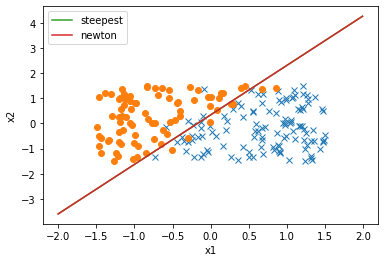

In [ ]:
np.random.seed(1024)

MAX_ITERATION = 2000
n,x,y = generate_data()
lam = 0.01
w_gd, w_history_gd, loss_history_gd = steepest_gradient_discent(x,y,lam)
w_nt, w_history_nt, loss_history_nt = newton_method(x,y,lam)

# 第二成分までを使ったときの決定境界を描画（実際にはw[2:]は非ゼロ）
plot_2Ddata(x, y)
xs = np.arange(-2,2,0.01)
ys = (-w_gd[0]*xs-w_gd[-1])/w_gd[1]
plt.plot(xs, ys, label="steepest")
ys = (-w_nt[0]*xs-w_nt[-1])/w_nt[1]
plt.plot(xs, ys, label="newton")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()

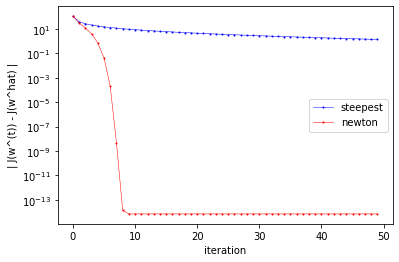

In [ ]:
# | J(w^(t)) - J(w^hat) | のプロット
loss_w_hat = min(min(loss_history_gd), min(loss_history_nt))
show_iter = 50
plt.plot(np.abs(loss_history_gd[:show_iter]-loss_w_hat), "bo-", linewidth=0.5, markersize=1, label="steepest")
plt.plot(np.abs(loss_history_nt[:show_iter]-loss_w_hat), "ro-", linewidth=0.5, markersize=1, label="newton")
plt.yscale("log")
plt.ylabel("| J(w^(t)) - J(w^hat) |")
plt.xlabel("iteration")
plt.legend()
plt.show()

# Multiclass classification

In [ ]:
def steepest_gradient_discent_multi(C, x, y, lam):
  n = len(x)
  d = x.shape[1]
  D = d+1
  w = np.zeros((d+1, C))
  x = np.hstack([x, np.ones((n,1))]) # オフセットのために各列に1を追加する
  # 正解クラスのみ1のn*C行列
  t = np.array([[j == y[i] for j in range(C)] for i in range(n)])
  
  MAX_BACKTRACKING = 20
  rho = 0.6
  loss_history = []
  w_history = []
  for it in range(MAX_ITERATION):
    # 記録
    # expxw[i,k] = exp(w_k^T x_i), p[i, k] = exp(w_k^T x_i)/sum_k(exp(w_k^T x_i))
    expxw = np.exp(np.dot(x, w))
    sumexp = np.sum(expxw, axis=1)
    p = expxw / sumexp[:, np.newaxis]
    loss = - np.sum(t * np.log(p)) + lam * np.sum(w * w)
    w_history.append(w)
    loss_history.append(loss)
    
    # 更新
    # w_flat[k*D:(k+1)*D] = w[:,k]となるように変形
    w_flat = w.T.flatten()
    grad_flat = np.concatenate([np.sum((p[:,k]-t[:,k])[:, np.newaxis] * x, axis=0) + 2 * lam * w[:,k] for k in range(C)])
    alpha = 1
    # 直線探索
    for _ in range(MAX_BACKTRACKING):
      w_flat_next = w_flat - alpha * grad_flat
      # 次のwを(D, C)に変形して次のlossを計算する
      w_next = w_flat_next.reshape((C, D)).T
      expxw_next = np.exp(np.dot(x, w_next))
      sumexp_next = np.sum(expxw_next, axis=1)
      p_next = expxw_next / sumexp_next[:, np.newaxis]
      loss_next = - np.sum(t * np.log(p_next)) + lam * np.sum(w_next * w_next)
      if loss_next <= loss:
        break
      alpha *= rho
    w_flat = w_flat - alpha * grad_flat
    w = w_flat.reshape((C, D)).T
        
  return w, w_history, loss_history

In [ ]:
def newton_method_multi(C, x, y, lam):
  n = len(x)
  d = x.shape[1]
  D = d+1
  w = np.zeros((D, C))
  x = np.hstack([x, np.ones((n,1))]) # オフセットのために各列に1を追加する
  t = np.array([[j == y[i] for j in range(C)] for i in range(n)])
  
  loss_history = []
  w_history = []
  for it in range(MAX_ITERATION):
    w_history.append(w)
    expxw = np.exp(np.dot(x, w))
    sumexp = np.sum(expxw, axis=1)
    p =  expxw / sumexp[:, np.newaxis]
    grad = np.zeros(C*D)
    hess = np.zeros((C*D, C*D))
    for k in range(C):
      # 勾配dJ/dw_k
      grad[k*D:(k+1)*D] = np.dot(x.T, p[:,k]-t[:,k]) + 2*lam*w[:,k]
    for k in range(C):
      for j in range(C):
        R = np.diag(p[:,k]*((k==j) - p[:,j]))
        # へシアンのdJ/dw_kdw^T_j部分
        hess[k*D:(k+1)*D, j*D:(j+1)*D] = np.dot(x.T, np.dot(R, x))
    # 正則化部分
    hess += 2 * lam * np.eye(C*D)
    loss = - np.sum(t * np.log(p)) + lam * np.sum(w * w)
    loss_history.append(loss)
    hess_inv = np.linalg.pinv(hess)
    # 重みの更新
    v = np.dot(hess_inv, grad)
    for k in range(C):
      w[:,k] -= v[k*D:(k+1)*D]
  return w, w_history, loss_history

In [ ]:
np.random.seed(1024)

MAX_ITERATION=2000
C,x,y = generate_data_multi()
lam = 0.01

In [ ]:
w_gd, w_history_gd, loss_history_gd = steepest_gradient_discent_multi(C,x,y,lam)
w_gd, loss_history_gd[:10]

(array([[  6.53841198, -10.03169054,   3.49327856],
        [ -4.75599778,   2.25859438,   2.49740339],
        [  0.23941236,   0.42889153,  -0.66830389],
        [  0.08687751,  -0.24846576,   0.16158824],
        [ -2.16221286,  -2.2239337 ,   4.38614657]]),
 [219.72245773362195,
  161.58418040105937,
  102.09834390872926,
  47.12547014059421,
  46.35787956944209,
  39.5627003387163,
  37.71588517406738,
  36.79203718939792,
  36.41345412277401,
  36.35569849981141])

In [ ]:
w_nt, w_history_nt, loss_history_nt = newton_method_multi(C,x,y,lam)
w_nt, loss_history_nt[:10]

(array([[  6.53841199, -10.03169054,   3.49327856],
        [ -4.75599778,   2.25859438,   2.4974034 ],
        [  0.23941236,   0.42889153,  -0.66830389],
        [  0.08687752,  -0.24846576,   0.16158824],
        [ -2.16221286,  -2.2239337 ,   4.38614656]]),
 [219.72245773362195,
  97.31202799818668,
  65.79584237646813,
  46.19370626329464,
  36.24192916440829,
  32.43254700231415,
  31.464644228567586,
  31.354385280544964,
  31.351977527876965,
  31.351975869619398])

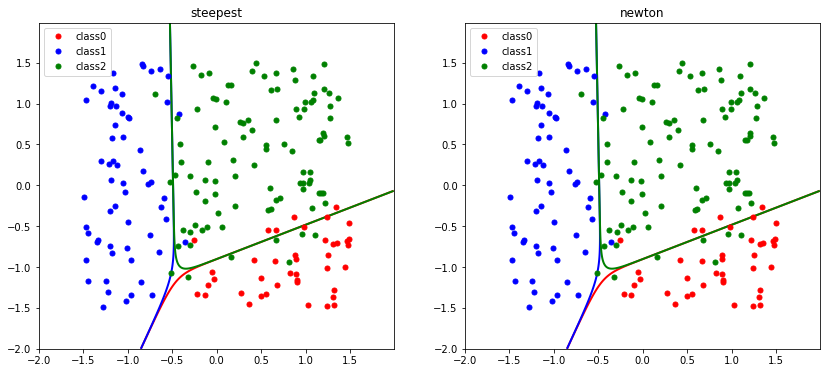

In [ ]:
# w[:2,:]とw[-1,:]（オフセット）を使ったときのp(k|x1,x2) = 0.5の等高線を描画する
colors = ["red", "blue", "green"]
X1, X2 = np.meshgrid(np.arange(-2,2, 0.01), np.arange(-2,2,0.01))
x_points = np.stack([X1.flatten(), X2.flatten()], axis=1)
ws = [w_gd, w_nt]
fig = plt.figure(figsize=(14,6))
axs = [fig.add_subplot(1,2,1), fig.add_subplot(1,2,2)]
axs[0].set_title("steepest")
axs[1].set_title("newton")
for i in range(len(ws)):
  w = ws[i]
  ax = axs[i]
  expxw = np.exp(np.dot(x_points, w[:2,:]) + w[-1,:])
  sumexp = np.sum(expxw, axis=1)
  for k in range(C):
    # plot k-class data
    xk = x[y==k]
    ax.plot(xk[:,0], xk[:,1], "o", markersize=5, color=colors[k], label=f"class{k}")
    # plot p(k|x1,x2) = 0.5
    p = expxw[:,k] / sumexp
    ax.contour(X1,X2,p.reshape(X1.shape), linewidths=2, colors=[colors[k]], levels=[0.5])
  ax.legend()

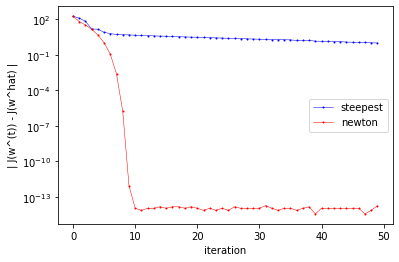

In [ ]:
loss_w_hat = min(min(loss_history_gd), min(loss_history_nt))
show_iter = 50
plt.plot(np.abs(loss_history_gd[:show_iter]-loss_w_hat), "bo-", linewidth=0.5, markersize=1, label="steepest")
plt.plot(np.abs(loss_history_nt[:show_iter]-loss_w_hat), "ro-", linewidth=0.5, markersize=1, label="newton")
plt.yscale("log")
plt.ylabel("| J(w^(t)) - J(w^hat) |")
plt.xlabel("iteration")
plt.legend()
plt.show()